# Construction des dictionnaires pour la Correction Lexicale

Dans ce notebook sera présenté le pré-traitement du jeu de donnée [Lexique3](https://chrplr.github.io/openlexicon/datasets-info/) afin d'obtenir des données utilisable par notre algorithme de correction lexicale.

Ce pré-traitement de donnée aura plusieurs objectif :
- Nettoyer le jeu de données de toutes ses impuretés (doublons, accents, etc...)
- Augmenter la vitesse de notre algo de correction lexicale en divisant le dataset

**Pour exécuter le notebook, mettre le dossier xlsx de Lexique3 dans le dossier dataset en le nommant liste_de_mots.xlsx**

## Importation des ressources nécessaires

### Importation des dépandances.

In [1]:
from pathlib import Path
from unidecode import unidecode
import pandas as pd
import matplotlib.pyplot as plt

### Importation du dataset en format excel


In [2]:
data = pd.read_excel(io="../dataset/liste_de_mots.xlsx", dtype=str)
print(data.head(10))

         ortho       phon        lemme cgram genre nombre freqlemfilms2  \
0            a          a            a   NOM     m    NaN         81.36   
1            a          a        avoir   AUX   NaN    NaN      18559.22   
2            a          a        avoir   VER   NaN    NaN       13572.4   
3    a capella    akapEla    a capella   ADV   NaN    NaN          0.04   
4   a cappella    akapEla   a cappella   ADV   NaN    NaN          0.04   
5  a contrario  ak§tRaRjo  a contrario   ADV   NaN    NaN             0   
6   a fortiori  afORsjoRi   a fortiori   ADV   NaN    NaN          0.04   
7     a giorno   adZjORno     a giorno   ADV   NaN    NaN             0   
8       a jeun        aZ1       à jeun   ADV   NaN    NaN          1.45   
9   a l'instar    al5staR   a l'instar   PRE   NaN    NaN          0.26   

  freqlemlivres freqfilms2 freqlivres  ...     orthrenv   phonrenv  \
0         58.65      81.36      58.65  ...            a          a   
1      12800.81    6350.91    2926

## Pré-traitement des données pour la création du dataset

### Organisation du dataset

Récupération des colonnes utiles, dans notre cas nous avons juste besoin de la colonne **ortho** pour **orthographe** des mots.

In [3]:
dataset =  pd.DataFrame(data["ortho"], dtype=str)
dataset.drop_duplicates(keep = 'first', inplace=True) # Supression des doublons
print(dataset.head(10))

           ortho
0              a
3      a capella
4     a cappella
5    a contrario
6     a fortiori
7       a giorno
8         a jeun
9     a l'instar
10  a posteriori
11      a priori


### Nettoyage du dataset

#### Suppression des accents et autres caractères français compliquant l'utilisation du jeu de données

In [4]:
print("Avant conversion")
print(dataset.tail())

Avant conversion
          ortho
142685  ôtèrent
142686      ôté
142688     ôtée
142690    ôtées
142692     ôtés


Opération de conversion des str avec accents en str sans accents

In [5]:
dataset = dataset.applymap(unidecode)
dataset.head(10)

print("Après conversion")
print(dataset.tail())

Après conversion
          ortho
142685  oterent
142686      ote
142688     otee
142690    otees
142692     otes


### Triage le dataset

Le tri du dataset par nombre de lettre aura pour but de séparer le dataset en sous fichier pour ainsi augmenter la vitesse de calcule de "la distance de Levensthein" en sélectionnant ces fichers en fonctions du mot demandé

#### Analyse de la répartition des mots par nombre de caractères dans le dataset

Pour cela, on crée une nouvelle colonne nb_caractères qui contiendra le nombre de caractères contenue dans chaque mots en fonction de la ligne de celui-ci

In [6]:
dataset_nb_caracteres = dataset.applymap(len)
dataset_nb_caracteres.head()

,ortho
0,1
3,9
4,10
5,11
6,10


Création du nouveau dataframe "dataset_3" contenant comme colonne:
-mot
-nombre de caractères

In [7]:
dataset_2 = pd.DataFrame({"mot": dataset["ortho"], "nb_caracteres": dataset_nb_caracteres["ortho"]})
dataset_2.head()

,mot,nb_caracteres
0,a,1
3,a capella,9
4,a cappella,10
5,a contrario,11
6,a fortiori,10


Affichage de l'histogramme de la répartition du nombre de mots en fonction du nombre de caractère.

<AxesSubplot: >

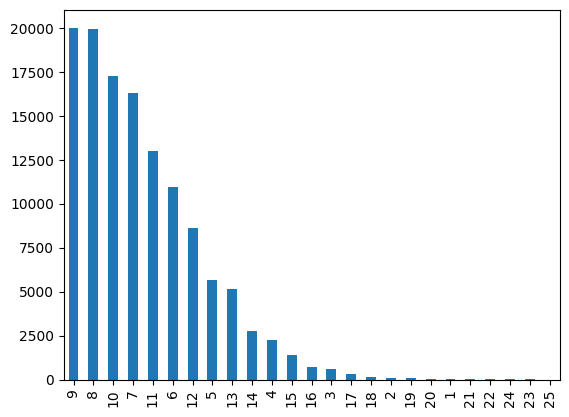

In [8]:
dataset_2["nb_caracteres"].value_counts().plot(kind="bar")

#### Regroupement des mots par nombre de caractère.

On regroupe les mots par nombre de caractère afin d'obtenir une répartition plus uniformes des ensembles de mots

In [9]:
dict_dataset_mots_par_nb_carac = {}
for i in range(1, 26):
    df = dataset_2 # Varaible intermédiaire pour simplifier l'écriture de la ligne suivante
    dict_dataset_mots_par_nb_carac[i] = df[df["nb_caracteres"] == i]["mot"] # On sélectionne uniquement la colonne des mots; plus besoin de la colonne du nombre de caractères

dict_dataset_mots_par_nb_carac[1]

0         a
12104     b
19237     c
34926     d
46861     e
54699     f
60589     g
67816     i
73954     j
75126     k
75459     l
78755     m
86465     n
88628     o
103794    q
117200    s
126652    t
133411    u
133900    v
137226    w
137326    x
137349    y
137441    z
137701    a
137798    e
142663    o
Name: mot, dtype: object

#### Regroupement des catégories où il y a peu de mots ensemble

Dans notre cas on va créer une nouvelle catégorie qui va reprendre tous les mots ayant les nombres de caractères ci-dessous:
**(14, 4, 15, 3, 16, 17, 2, 18, 19, 1, 20, 21, 22, 23, 24, 25)**.

In [10]:
groupe_autre = [14, 4, 15, 3, 16, 17, 2, 18, 19, 1, 20, 21, 22, 23, 24, 25]
dataset_autre = pd.DataFrame(dtype=str)

for i in groupe_autre:
    dataset_autre = pd.concat((dataset_autre, dict_dataset_mots_par_nb_carac[i]))
dataset_autre.columns = ["mot"]
dataset_autre

,mot
27,abaisse-langue
69,abandonnerions
99,abasourdissant
270,abolitionniste
275,abominablement
...,...
90750,oto-rhino-laryngologique
90751,oto-rhino-laryngologiste
120238,sic transit gloria mundi
123395,sterno-cleido-mastoidien


##### Création du dataset final dans un dictionnaire

In [11]:
dict_final_dataset = {}
dict_final_dataset["autre"] = dataset_autre

for i in range(1, 26):
    if i not in groupe_autre:
        dict_final_dataset[i] = dict_dataset_mots_par_nb_carac[i]

##### Affichage de la répartition des ensembles de  mots

{'autre': 8497, 5: 5684, 6: 10956, 7: 16335, 8: 19981, 9: 20039, 10: 17300, 11: 13038, 12: 8653, 13: 5170}


([<matplotlib.axis.XTick at 0x7f24f4684cd0>,
 [Text(0, 0, 'autre'),
  Text(1, 0, '5'),
  Text(2, 0, '6'),
  Text(3, 0, '7'),
  Text(4, 0, '8'),
  Text(5, 0, '9'),
  Text(6, 0, '10'),
  Text(7, 0, '11'),
  Text(8, 0, '12'),
  Text(9, 0, '13')])

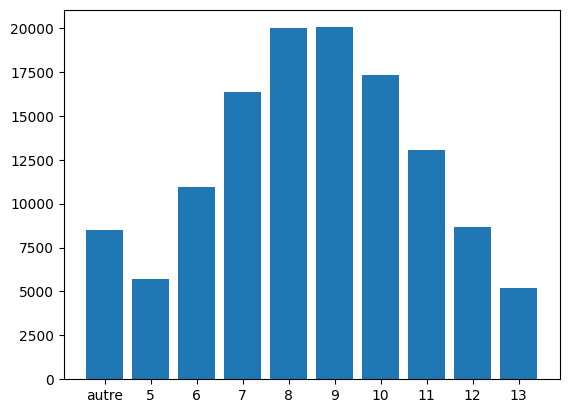

In [12]:
dict_final_dataset_repartion_mots = {}

for key, value in dict_final_dataset.items():
    dict_final_dataset_repartion_mots[key] = len(value.index)

print(dict_final_dataset_repartion_mots)
plt.bar(range(len(dict_final_dataset_repartion_mots)), list(dict_final_dataset_repartion_mots.values()), align='center')
plt.xticks(range(len(dict_final_dataset_repartion_mots)), list(dict_final_dataset_repartion_mots.keys()))

##### Sauvegarde du dataset sur le PC

In [13]:
SAVE_PATH = Path("../dataset/")
for key in dict_final_dataset.keys():
    dict_final_dataset[key].to_csv(SAVE_PATH / f"mots_{key}.csv", index=False)